In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib as plt
%matplotlib inline

In [ ]:
print(os.listdir("../input"))

['iris.csv']


In [3]:
iris_data = pd.read_csv('./input/iris.csv')
iris_data.shape

(150, 5)

In [4]:
iris_data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


# Data Visualization
Gain some intuition for the data set. 

array([[<Axes: title={'center': 'Setosa'}>,
        <Axes: title={'center': 'Versicolor'}>],
       [<Axes: title={'center': 'Virginica'}>, <Axes: >]], dtype=object)

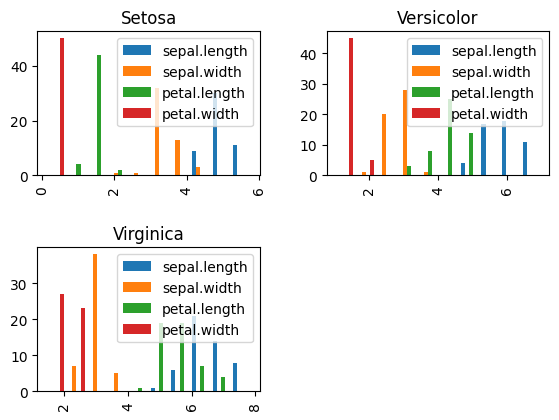

In [5]:
iris_data.hist(by='variety', legend=True)

array([[<Axes: title={'center': 'Setosa'}>,
        <Axes: title={'center': 'Versicolor'}>],
       [<Axes: title={'center': 'Virginica'}>, <Axes: >]], dtype=object)

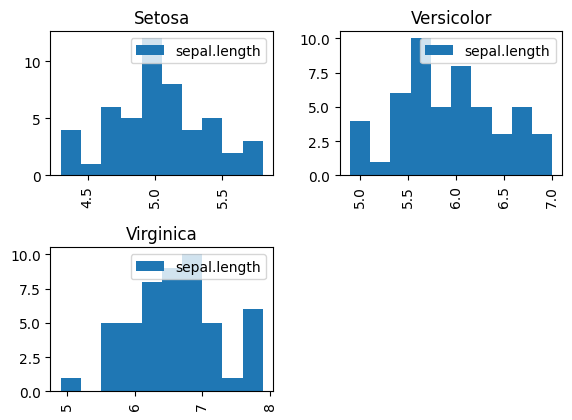

In [6]:
iris_data.hist(column='sepal.length', by='variety', legend=True)

# k-fold cross-validation
Randomly shuffle dataset and split into k segments. We train and test the model k times: For every ith segment of k, train the model on the other k-1 segments and test on segment i. Evaluate the model's performance on the average of all k runs. k=10 is commonly chosen.

In [7]:
shuffled_data = iris_data.sample(frac=1) # shuffle data
shuffled_data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
116,6.5,3.0,5.5,1.8,Virginica
146,6.3,2.5,5.0,1.9,Virginica
33,5.5,4.2,1.4,0.2,Setosa
27,5.2,3.5,1.5,0.2,Setosa
25,5.0,3.0,1.6,0.2,Setosa


In [8]:
import math
i = 3
k = 10
step_size = math.floor(shuffled_data.shape[0]/k)
testset = shuffled_data[i*step_size : i*step_size+step_size]

trainset = pd.concat([shuffled_data[:i*step_size-1], shuffled_data[i*step_size+step_size-1:]])
trainset.shape

(135, 5)

In [9]:
df = trainset.sort_values(by=['sepal.length'], ignore_index=True)
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,4.3,3.0,1.1,0.1,Setosa
1,4.4,2.9,1.4,0.2,Setosa
2,4.4,3.0,1.3,0.2,Setosa
3,4.5,2.3,1.3,0.3,Setosa
4,4.6,3.6,1.0,0.2,Setosa


In [10]:
i = 3
k = 10
shuffled_data = iris_data.sample(frac=1) # shuffle data

def get_train_test_split(i, k, shuffled_data) :
    step_size = math.floor(shuffled_data.shape[0]/k)
    testset = shuffled_data[i*step_size : i*step_size+step_size]

    trainset = pd.concat([shuffled_data[:i*step_size-1], shuffled_data[i*step_size+step_size-1:]])
    trainset.shape
    return trainset, testset

trainset, testset = get_train_test_split(i, k, shuffled_data)

# Decision Tree
Determine threshold values for sepal.length, sepal.width, petal.length and petal.width that make it more likely for the data point to be of a specific iris variety. Useful Link: https://www.youtube.com/watch?v=_L39rN6gz7Y
Steps:
    1. determine which feature is most "meaningful", this should evaluated at the root --> Gini impurity (other methods: Entropy, Information Gain)

## Gini Impurity for numerical data
 
formula:
gini impurity for a leaf = 1-P(Yes)^2-P(No)^2

In [15]:
def calc_gini_impurity(df, feature, variety) : 
    min_gini = 1
    threshold = 0
    direction = 'none'
    for i in range(df.shape[0]-1) :
        # step 1: calculate average between pairs in the sorted feature column as potential thresholds
        #feature_idx= df[feature]
        #print(i, feature, feature_idx)
        avg = (df[feature].iloc[i] + df[feature].iloc[i+1])/2
    
        # step 2: separate df by threshold
        left_branch = df[df[feature] < avg]
        right_branch = df[df[feature] >= avg]
        
        #print(left_branch.shape[0], right_branch.shape[0])
        if left_branch.shape[0] == 0 or right_branch.shape[0] == 0: continue
    
        # step 3: separate branches by variety (yes/no)
        l_vc_yes = left_branch[left_branch['variety'] == variety].shape[0]
        r_vc_yes = right_branch[right_branch['variety'] == variety].shape[0]
    
        l_vc_no = left_branch.shape[0] - l_vc_yes
        r_vc_no = right_branch.shape[0] - r_vc_yes
    
        # step 5 calculate Gini Impurity
        gini_left = 1 - (l_vc_yes/left_branch.shape[0])**2 - (l_vc_no/left_branch.shape[0])**2
        gini_right = 1 - (r_vc_yes/right_branch.shape[0])**2 - (r_vc_no/right_branch.shape[0])**2
    
        total_gini = (left_branch.shape[0]/df.shape[0]) * gini_left + (right_branch.shape[0]/df.shape[0]) * gini_right
        if total_gini < min_gini : 
            min_gini = total_gini
            threshold = avg
            if l_vc_yes > r_vc_yes : direction = 'left'
            else : direction = 'right'
    
    return(min_gini, threshold, direction) #l_g, r_g, l_yes, r_yes, l_no, r_no)

In [16]:
for variety in df['variety'].unique(): 
    print(f'\n{variety}:')
    for feature in df.columns[:-1]:
        print(f'Gini for {feature}: {calc_gini_impurity(df, feature, variety)}')

SyntaxError: 'return' outside function (3514452231.py, line 5)

The lowest  Gini impurity is for petal.length < 3.0 for Setosa. This will be our root node and appears to be enough to classify Setosa (GI = 0). Let's now determine the Gini impurity  again with the assumption that petal_length >= 3.0

In [12]:
df = df[df['petal.length'] >= 3.0]
df = df[df['variety'] != 'Setosa']
df.shape[0]

88

In [13]:
for variety in df['variety'].unique(): 
    print(f'\n{variety}:')
    for feature in df.columns[:-1]:
        print(f'Gini for {feature}: {calc_gini_impurity(df, feature, variety)}')


Virginica:


NameError: name 'calc_gini_impurity' is not defined

The lowest Gini impurity is for petal.width < 1.8. This appears to already separate the data enough. 

## Building Decision Tree Model

In [ ]:
def branch(df, feature, threshold) : 
    left = df[df[feature] < threshold]
    right = df[~left]
    

def predict_variety(testset) : 
    testset = testset.copy()
    testset['prediction'] = 'NaN'
    # separate data by petal_length < 3: We predict these all to be Setosa
    left = testset[testset['petal.length'] < 3]
    left['prediction'] = 'Setosa'
    
    # now separate by petal_width Prediction: < 1.8 ---> Versicolor, otherwise Virginica 
    right = testset[testset['petal.length'] >= 3]
    pw_left = right[right['petal.width'] < 1.8]
    pw_right = right[right['petal.width'] >= 1.8]
    pw_left['prediction'] = 'Versicolor'
    pw_right['prediction'] = 'Virginica'
    
    total = pd.concat([left, pw_left, pw_right])
    return total

predict_variety(testset)

## Evaluating Decision Tree

In [ ]:
def evaluate_model(testset) : 
    pred = predict_variety(testset)
    hits = pred[pred['variety'] == pred['prediction']].shape[0]
    return hits/pred.shape[0]

#evaluate_model(testset)